<a href="https://colab.research.google.com/github/apal9569/PPO/blob/main/PPO_5_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import copy
import gym
import numpy as np
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch import nn
from torch.distributions import Normal
from collections import deque
import torch.nn.functional as F
from IPython.display import clear_output
import matplotlib.pyplot as plt

import random

batch_size = 50
epochs = 1000
learning_rate = 1e-2
n_layers = 2
gamma = 0.99

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
class PolModel(nn.Module):
    def __init__(self, in_dim):
        super(PolModel, self).__init__()

        self.fc1 = nn.Linear(in_dim, 64)
        self.fc2 = nn.Linear(64,64)
        self.mu = nn.Linear(64, 1)
        self.std = nn.Linear(64,1)

        self.tanh  = nn.Tanh()
        self.relu = nn.LeakyReLU()

    def forward(self, x):

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        mu = self.tanh(self.mu(x))
        std = torch.exp(self.tanh(self.std(x)))
        dist = Normal(mu, std)
  
        return dist
    
    def sample_act(self,state):
        dist = self.forward(state)
        action = dist.sample()
        return dist, torch.clamp(action, -2., 2.)
    
class ValModel1(nn.Module):
    def __init__(self, in_dim):
        super(ValModel1, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ValModel2(nn.Module):
    def __init__(self, in_dim):
        super(ValModel2, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ValModel3(nn.Module):
    def __init__(self, in_dim):
        super(ValModel3, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ValModel4(nn.Module):
    def __init__(self, in_dim):
        super(ValModel4, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ValModel5(nn.Module):
    def __init__(self, in_dim):
        super(ValModel5, self).__init__()
        self.fc1 = nn.Linear(in_dim, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class History:
    def __init__(self):
        self.states, self.actions, self.rewards, self.log_probs, self.values, self.dones = [], [], [], [], [], []
    
    def append(self, state, action, log_prob, value, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()
        self.dones.clear()
        self.log_probs.clear()
        self.values.clear()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
env = gym.make("Pendulum-v1")
gamma = 0.9
epsilon = 0.2

data_collections = 1000
train_epoch = 30
obs_dim = 3


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def dataCollection():
    score = 0
    state = np.reshape(env.reset(), (1, -1))

    for _ in range(data_collections):
        state = torch.FloatTensor(state).to(device)
        dist, action = polModel.sample_act(state)

        value1 = valModel1(state)
        value2 = valModel2(state)
        value3 = valModel3(state)
        value4 = valModel4(state)
        value5 = valModel5(state)
        value = (value1 + value2 + value3 + value4 + value5)/5.0

        action_taken = action.detach().cpu().numpy()[0]
        next_state, reward, done, _ = env.step(action_taken)

        next_state = np.reshape(next_state, (1, -1))
        reward = np.reshape(reward, (1, -1))
        done = np.reshape(done, (1, -1))

        history.append(state, action, dist.log_prob(action), value, torch.FloatTensor(reward).to(device), torch.FloatTensor(1 - done).to(device))
        
        state = next_state
        score += reward[0][0]

        if done[0][0]:
            scores.append(score)
            score = 0
            state = env.reset()
            state = np.reshape(state, (1, -1))
    
    value1 = valModel1(torch.FloatTensor(next_state))
    value2 = valModel2(torch.FloatTensor(next_state))
    value3 = valModel3(torch.FloatTensor(next_state))
    value4 = valModel4(torch.FloatTensor(next_state))
    value5 = valModel5(torch.FloatTensor(next_state))
    value = (value1 + value2 + value3 + value4 + value5)/5.0

    history.values.append(value)
    # scores.append(score)


In [ ]:
def trainModel(config):

    Qs = []
    Adv = 0
    ####Considered lamda = 1
    for i in reversed(range(len(history.rewards))):
        delta = (history.rewards[i] + gamma * history.values[i + 1] * history.dones[i] - history.values[i])
        Adv = delta + 0.95 * gamma * history.dones[i] * Adv
        Qs.insert(0, Adv + history.values[i])
        
    actor_losses, critic_losses = [], []

    states = torch.cat(history.states).view(-1, obs_dim)
    actions = torch.cat(history.actions)
    Qs = torch.cat(Qs).detach()
    log_probs = torch.cat(history.log_probs).detach()
    values = torch.cat(history.values).detach()
    advantages = Qs - values[:-1] 

    for _ in range(train_epoch):
        for batch_use in range(states.size(0) // batch_size):
          stop = states.size(0) if batch_size * (batch_use+1) > states.size(0) else batch_size * (batch_use+1)
          ids = np.arange(batch_size * batch_use, batch_size * (batch_use+1), 1)
          state = states[ids, :]
          action = actions[ids]
          Q = Qs[ids]
          old_log_prob = log_probs[ids]
          advantage = advantages[ids]

          dist, _  = polModel.sample_act(state)
          cur_log_prob = dist.log_prob(action)
          ratio = torch.exp(cur_log_prob - old_log_prob)

          entropy = dist.entropy().mean()

          loss =  advantage * ratio

          cur_value1 = valModel1(state)
          cur_value2 = valModel2(state)
          cur_value3 = valModel3(state)
          cur_value4 = valModel4(state)
          cur_value5 = valModel5(state)

          critic_loss1 = torch.mean(torch.square(Q - cur_value1))
          critic_loss_copy1 = copy.deepcopy(critic_loss1.clone().detach().numpy())
          critic_loss2 = torch.mean(torch.square(Q - cur_value2))
          critic_loss_copy2 = copy.deepcopy(critic_loss2.clone().detach().numpy())
          critic_loss3 = torch.mean(torch.square(Q - cur_value3))
          critic_loss_copy3 = copy.deepcopy(critic_loss3.clone().detach().numpy())
          critic_loss4 = torch.mean(torch.square(Q - cur_value4))
          critic_loss_copy4 = copy.deepcopy(critic_loss4.clone().detach().numpy())
          critic_loss5 = torch.mean(torch.square(Q - cur_value5))
          critic_loss_copy5 = copy.deepcopy(critic_loss5.clone().detach().numpy())

          critic_loss_copy = (critic_loss_copy1 + critic_loss_copy2 +critic_loss_copy3 +critic_loss_copy4 +critic_loss_copy5)/5.0

          if config[0]:
            if config[1]:
              clipped_loss = (torch.clamp(ratio, 1. - epsilon, 1. + epsilon) * advantage - entropy * 0.001 - critic_loss_copy * 0.001)
              actor_loss = -torch.mean(torch.min(loss, clipped_loss))
            else:
              clipped_loss = (torch.clamp(ratio, 1. - epsilon, 1. + epsilon)  - entropy * 0.005 - critic_loss_copy * 0.005)
              actor_loss = -torch.mean(torch.min(loss, clipped_loss))
          else:
            if config[1]:
              actor_loss = -torch.mean(loss) - ( - entropy * 0.005 )
            else:
              actor_loss = -torch.mean(ratio) - ( - entropy * 0.005 )
          
        
          pol_optimizer.zero_grad()
          actor_loss.backward()
          pol_optimizer.step()

          val_optimizer1.zero_grad()
          critic_loss1.backward()
          val_optimizer1.step()

          val_optimizer2.zero_grad()
          critic_loss2.backward()
          val_optimizer2.step()

          val_optimizer3.zero_grad()
          critic_loss3.backward()
          val_optimizer3.step()

          val_optimizer4.zero_grad()
          critic_loss4.backward()
          val_optimizer4.step()

          val_optimizer5.zero_grad()
          critic_loss5.backward()
          val_optimizer5.step()

          actor_losses.append(actor_loss.item())
          critic_losses.append(critic_loss_copy)
    actor_loss = sum(actor_losses) / len(actor_losses)
    critic_loss = sum(critic_losses) / len(critic_losses)
    total_actor_loss.append(actor_loss)
    total_critic_loss.append(critic_loss)
    history.clear()


In [ ]:
def _plot_train_history():
    data = [scores, np.array(total_actor_loss) + np.array(total_critic_loss)]
    labels = ["Score",
              "Total Loss"]

    clear_output(True)

    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    for i, ax in enumerate(axes):
        ax.plot(data[i])
        ax.set_title(labels[i])
    plt.tight_layout()
    plt.show()

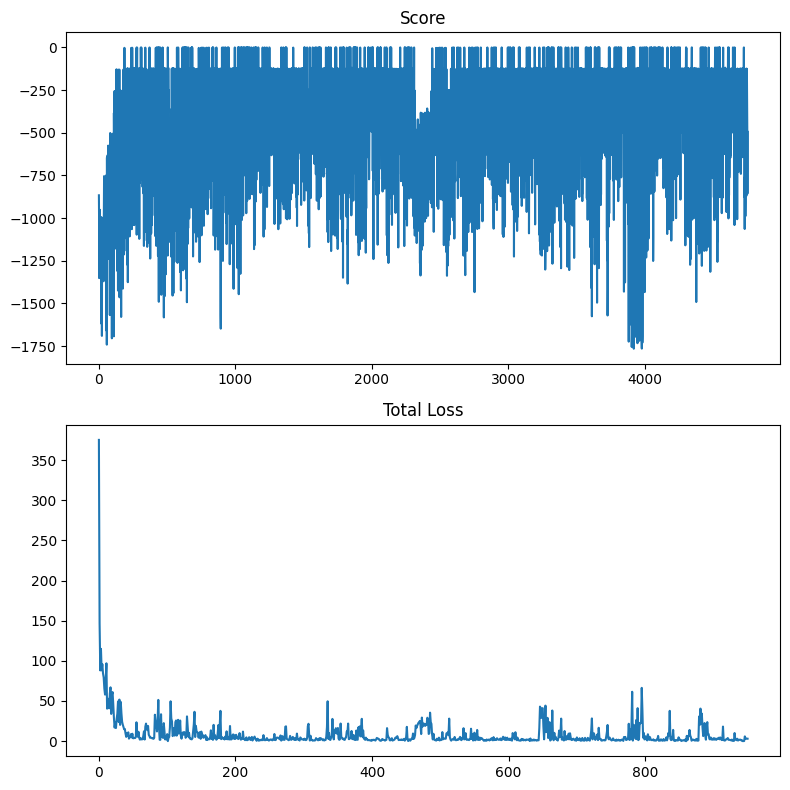

In [ ]:

for config in [[True, True]]:
  polModel = PolModel(obs_dim).to(device)

  valModel1 = ValModel1(obs_dim).to(device)
  valModel2 = ValModel2(obs_dim).to(device)
  valModel3 = ValModel3(obs_dim).to(device)
  valModel4 = ValModel4(obs_dim).to(device)
  valModel5 = ValModel5(obs_dim).to(device)

  pol_optimizer = optim.Adam(polModel.parameters(), lr=1e-3)

  val_optimizer1 = optim.Adam(valModel1.parameters(), lr=1e-3)
  val_optimizer2 = optim.Adam(valModel2.parameters(), lr=2e-3)
  val_optimizer3 = optim.Adam(valModel3.parameters(), lr=3e-3)
  val_optimizer4 = optim.Adam(valModel4.parameters(), lr=4e-3)
  val_optimizer5 = optim.Adam(valModel5.parameters(), lr=5e-3)

  history = History()
  total_actor_loss = []
  total_critic_loss = []
  scores = []

  for step in range(epochs):
    dataCollection()
    trainModel(config)
    if step%50 == 0:
      _plot_train_history()

In [ ]:
def _plot_train_history():
    data = [scores, np.array(total_actor_loss) + np.array(total_critic_loss)]
    labels = ["Score",
              "Total Loss"]

    clear_output(True)

    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    for i, ax in enumerate(axes):
        ax.plot(data[i])
        ax.set_title(labels[i])
        ax.set_xlabel("Epoch")
    plt.tight_layout()
    plt.show()

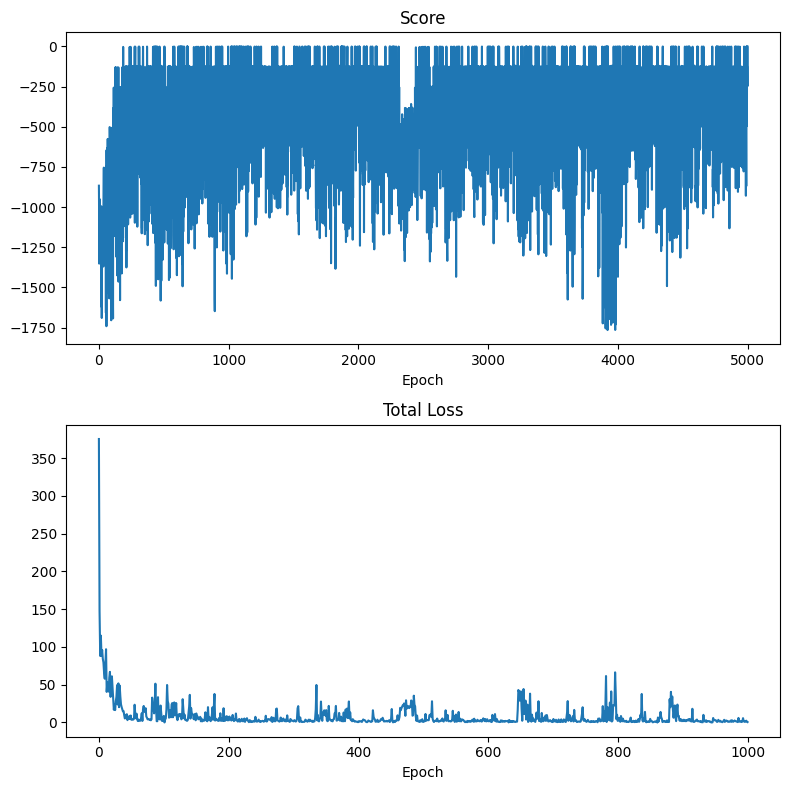

In [ ]:
_plot_train_history()